## Doctor appointment booking System

This chat agent can interact with users and perform the following tasks:

    1. Select a doctor and choose a time slot for booking

    2. Cancel a booked appointment

    3. Reschedule a booked appointment based on availability

    4. Search for doctor details filtered by name, availability, specialty, and location

### 1. Connect with Gemini API

connect to the llm using google api key.

In [1]:
# connect with gemini api
import getpass
import os

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")

In [2]:
# initialize llm chat model
from langchain_google_genai import ChatGoogleGenerativeAI
from google.genai.types import GenerateContentConfig


system_instruction = """
                        You are a phone-agent assistant.  
                        
                        Keep all messages very short—just a single question or one answer.  
                        
                        Act as if you’re on a live call: no long explanations or chit-chat.  
                        
                        Always reference prior chat context and stay aligned with the conversation.  
                        
                    """

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash-001",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    config=GenerateContentConfig(
        system_instruction=system_instruction,
    ),
    # other params...
)

### 2. State and Assistant class

This class is used to define specialized assistants based on each tasks

In [3]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages

# state of the graph
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_name: str # name of the current user
    user_id: str # id of the current user


class Assistant:
    # this initialize a runnable that can be prompt template | llm with tools
    # by doing that we can make any assistant with same code
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        # if the llm not produce a result
        # it safely update the state with in a node using state = {**state, "messages": messages}
        # normally state is updated after the node is executed 
        # in this case 
        while True:
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}

### 3. Completion of task and hand over to other assistant

This tool is called when the task is completed or the user intend to go another task

In [18]:
from pydantic import BaseModel, Field

class CompleteOrEscalate(BaseModel):
    """A tool to mark the current task as completed and/or to escalate control of the dialog to the main assistant,
    who can re-route the dialog based on the user's needs."""

    cancel: bool = True
    reason: str

    class Config:
        json_schema_extra = {
            "example": {
                "cancel": True,
                "reason": "User changed their mind about the current task."
            }
        }


### 4. Create DataBase and insert sample data to that

This make a database and add some sample data 

In [19]:
DB_PATH = "hospital3.db"

In [12]:
import sqlite3
from datetime import datetime

# Step 1: Connect
DB_PATH = "hospital3.db"
conn = sqlite3.connect(DB_PATH) 
cursor = conn.cursor()

# Step 2: Create tables
cursor.execute("""
CREATE TABLE Doctor (
    Doctor_ID INTEGER PRIMARY KEY AUTOINCREMENT,
    Doctor_Name TEXT,
    Specialization TEXT,
    Location TEXT,
    Rating REAL
)
""")

cursor.execute("""
CREATE TABLE Patient (
    Patient_ID INTEGER PRIMARY KEY AUTOINCREMENT,
    Patient_Name TEXT,
    Age INTEGER
)
""")

cursor.execute("""
CREATE TABLE Appointment (
    Appointment_ID INTEGER PRIMARY KEY AUTOINCREMENT,
    Appointment_Time TEXT,
    Appointment_Date TEXT,
    Doctor_ID INTEGER,
    Patient_ID INTEGER,
    FOREIGN KEY (Doctor_ID) REFERENCES Doctor(Doctor_ID),
    FOREIGN KEY (Patient_ID) REFERENCES Patient(Patient_ID)
)
""")

# Insert data into Doctor and Patient tables
doctors = [
    ("Dr. Alice Smith", "Cardiology", "New York", 4.7),
    ("Dr. Bob Johnson", "Neurology", "Los Angeles", 4.5),
    ("Dr. Clara Lee", "Pediatrics", "Chicago", 4.8)
]

patients = [
    ("John Doe", 30),
    ("Emily Davis", 25),
    ("Michael Brown", 45)
]

cursor.executemany("INSERT INTO Doctor (Doctor_Name, Specialization, Location, Rating) VALUES (?, ?, ?, ?)", doctors)
cursor.executemany("INSERT INTO Patient (Patient_Name, Age) VALUES (?, ?)", patients)

# Retrieve IDs
cursor.execute("SELECT Doctor_ID FROM Doctor ORDER BY Doctor_ID")
doctor_ids = [row[0] for row in cursor.fetchall()]

cursor.execute("SELECT Patient_ID FROM Patient ORDER BY Patient_ID")
patient_ids = [row[0] for row in cursor.fetchall()]

# Insert into Appointment table
appointments = [
    ("10:00", "2025-06-06", doctor_ids[0], patient_ids[0]),
    ("11:30", "2025-06-06", doctor_ids[1], patient_ids[1]),
    ("14:00", "2025-06-07", doctor_ids[2], patient_ids[2])
]

cursor.executemany("""
    INSERT INTO Appointment (Appointment_Time, Appointment_Date, Doctor_ID, Patient_ID)
    VALUES (?, ?, ?, ?)
""", appointments)

# Step 4: Commit and verify
conn.commit()

# Print the data
for row in cursor.execute("SELECT * FROM Appointment"):
    print(row)

# Close connection
conn.close()

(1, '10:00', '2025-06-06', 1, 1)
(2, '11:30', '2025-06-06', 2, 2)
(3, '14:00', '2025-06-07', 3, 3)


### 5. Tools for searching a Doctor and book an Appointment

In [42]:
from langchain_core.tools import tool
from typing import Optional, Dict, List
import sqlite3

# Tool to search for a doctor by name
@tool
def search_for_doctor(name: Optional[str] = None) -> List[Dict]:
    """
    Search for doctors by name (or return all if name is None).

    Args:
        name (Optional[str]): The partial or full name of the doctor.

    Returns:
        List[Dict]: Doctors matching the search criteria.
    """
    conn = sqlite3.connect(DB_PATH)
    conn.row_factory = sqlite3.Row
    cursor = conn.cursor()

    if name:
        cursor.execute("""
            SELECT * FROM Doctor WHERE Doctor_Name LIKE ?
        """, (f"%{name}%",))
    else:
        cursor.execute("SELECT * FROM Doctor")

    results = [dict(row) for row in cursor.fetchall()]
    conn.close()
    return results

# Tool to check a doctor's availability at a given date and time
@tool
def check_doctor_availability(doctor_id: int, date: str, time: str) -> Dict:
    """
    Check if a doctor is available at a given date and time.

    Args:
        doctor_id (int): The ID of the doctor.
        date (str): Date of the appointment in 'YYYY-MM-DD' format.
        time (str): Time of the appointment (e.g., '10:00').

    Returns:
        Dict: {"available": True/False}
    """
    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()

    cursor.execute("""
        SELECT 1 FROM Appointment
        WHERE Doctor_ID = ? AND Appointment_Date = ? AND Appointment_Time = ?
    """, (doctor_id, date, time))

    result = cursor.fetchone()
    conn.close()

    return {"available": result is None}

# Tool for book an appoinment and add to the database
@tool
def book_appointment(user_id: int, doctor_id: int, date: str, time: str) -> Dict:
    """
    Book an appointment with a doctor if available at the given date and time.

    Args:
        user_id (int): The ID of the patient.
        doctor_id (int): The ID of the doctor.
        date (str): Appointment date in 'YYYY-MM-DD' format.
        time (str): Appointment time in 'HH:MM' format.

    Returns:
        Dict: {"success": True/False, "message": str}
    """
    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()

    # Check if doctor is available
    cursor.execute("""
        SELECT 1 FROM Appointment
        WHERE Doctor_ID = ? AND Appointment_Date = ? AND Appointment_Time = ?
    """, (doctor_id, date, time))
    result = cursor.fetchone()

    if result:
        conn.close()
        return {"success": False, "message": "Doctor is not available at this date and time."}

    # Book appointment
    cursor.execute("""
        INSERT INTO Appointment (Appointment_Time, Appointment_Date, Doctor_ID, Patient_ID)
        VALUES (?, ?, ?, ?)
    """, (time, date, doctor_id, user_id))
    conn.commit()
    conn.close()

    return {"success": True, "message": "Appointment booked successfully."}


In [43]:
from langchain_core.prompts import ChatPromptTemplate
from datetime import datetime

book_doctor_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a specialized assistant for handling doctor appointment bookings. "
            "The primary assistant delegates work to you whenever the user needs help finding a doctor or scheduling an appointment. "
            "Search for doctors based on the user's preferences (name, specialization, location), and check their availability for a given date and time. "
            "Confirm the details with the user before attempting to book the appointment. "
            "If the doctor is unavailable, offer alternate time slots or suggest a similar doctor. "
            "Always confirm availability before booking. "
            "Do not proceed with a booking unless the relevant tool has successfully returned availability."
            "\nCurrent time: {time}."
            '\n\nIf the user needs help outside of your scope, then "CompleteOrEscalate" the dialog to the main assistant. '
            "Do not make up tools or waste the user's time."
            "\n\nSome examples where you should CompleteOrEscalate:\n"
            " - 'I'm looking for medical insurance info'\n"
            " - 'I want to book a hospital room'\n"
            " - 'Actually, I’ll call the clinic myself'\n"
            " - 'I want to book a flight to the hospital location first'\n"
            " - 'Doctor appointment already confirmed'\n",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

book_appointment_tools = [check_doctor_availability, search_for_doctor, book_appointment]
book_appointment_runnable = book_doctor_prompt | llm.bind_tools(
    book_appointment_tools + [CompleteOrEscalate]
)

### 6. Make the book appointment sub graph

This sub graph is resposible for select a doctor and book an appointment 

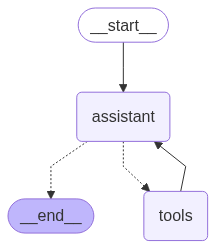

In [44]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langgraph.prebuilt import tools_condition,ToolNode

# make a sample graph to check working
graph_builder = StateGraph(State)

graph_builder.add_node("tools", ToolNode(book_appointment_tools))
graph_builder.add_node("assistant", Assistant(book_appointment_runnable))
graph_builder.add_edge("tools", "assistant")
graph_builder.add_conditional_edges("assistant", tools_condition)
graph_builder.set_entry_point("assistant")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [36]:
thread = {"configurable": {"thread_id": "1"}}
inputs = {"messages": [{"role": "user", "content": "I want to book appoinment to Dr. Janith"}]}
for chunk in graph.stream(inputs, thread, stream_mode="updates"):
    print(chunk)

Key 'example' is not supported in schema, ignoring
Key 'example' is not supported in schema, ignoring


{'assistant': {'messages': AIMessage(content='', additional_kwargs={'function_call': {'name': 'search_for_doctor', 'arguments': '{"name": "Janith"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--4d66f329-c45f-49e9-b7a6-6db18f58e30a-0', tool_calls=[{'name': 'search_for_doctor', 'args': {'name': 'Janith'}, 'id': 'd007f5d6-a4a3-487a-9075-ea6a1bcdc0bf', 'type': 'tool_call'}], usage_metadata={'input_tokens': 597, 'output_tokens': 8, 'total_tokens': 605, 'input_token_details': {'cache_read': 0}})}}
{'tools': {'messages': [ToolMessage(content=[], name='search_for_doctor', id='726f1e5f-6133-4421-8f65-544361add8a6', tool_call_id='d007f5d6-a4a3-487a-9075-ea6a1bcdc0bf')]}}
{'assistant': {'messages': AIMessage(content='I am sorry, I could not find a doctor by that name. Would you like me to search for a different doctor?', additional_kwargs={}, response_metadata={'pr

In [45]:
inputs = {"messages": [{"role": "user", "content": "okey can I find Dr. Alice"}]}
for chunk in graph.stream(inputs, thread, stream_mode="updates"):
    print(chunk)

Key 'example' is not supported in schema, ignoring
Key 'example' is not supported in schema, ignoring


{'assistant': {'messages': AIMessage(content='', additional_kwargs={'function_call': {'name': 'search_for_doctor', 'arguments': '{"name": "Alice"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--fed37008-5a37-4a91-b650-c2d341bb5a1b-0', tool_calls=[{'name': 'search_for_doctor', 'args': {'name': 'Alice'}, 'id': '79722622-bc59-49c1-b662-39adccca96af', 'type': 'tool_call'}], usage_metadata={'input_tokens': 593, 'output_tokens': 7, 'total_tokens': 600, 'input_token_details': {'cache_read': 0}})}}
{'tools': {'messages': [ToolMessage(content='[{"Doctor_ID": 1, "Doctor_Name": "Dr. Alice Smith", "Specialization": "Cardiology", "Location": "New York", "Rating": 4.7}]', name='search_for_doctor', id='19ff0512-39dc-46b6-9749-bf0d7014014e', tool_call_id='79722622-bc59-49c1-b662-39adccca96af')]}}
{'assistant': {'messages': AIMessage(content='OK. I found Dr. Alice Smith, 

In [46]:
inputs = {"messages": [{"role": "user", "content": "yea ,I want to book appoinment at 6 June 2025 at 10 am"}]}
for chunk in graph.stream(inputs, thread, stream_mode="updates"):
    print(chunk)

Key 'example' is not supported in schema, ignoring
Key 'example' is not supported in schema, ignoring


{'assistant': {'messages': AIMessage(content='', additional_kwargs={'function_call': {'name': 'check_doctor_availability', 'arguments': '{"doctor_id": 1.0, "date": "2025-06-06", "time": "10:00"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--d86f2a66-fbc4-45bc-995a-30beefd700db-0', tool_calls=[{'name': 'check_doctor_availability', 'args': {'doctor_id': 1.0, 'date': '2025-06-06', 'time': '10:00'}, 'id': 'e7c67632-c686-47ef-94b8-d6bec21582fd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 681, 'output_tokens': 26, 'total_tokens': 707, 'input_token_details': {'cache_read': 0}})}}
{'tools': {'messages': [ToolMessage(content='{"available": false}', name='check_doctor_availability', id='02f232a4-efa2-4e17-aa0b-b6a3cc969708', tool_call_id='e7c67632-c686-47ef-94b8-d6bec21582fd')]}}
{'assistant': {'messages': AIMessage(content='It seems Dr. Alice Smith is

In [47]:
inputs = {"messages": [{"role": "user", "content": "okey, can I book appoinment at 6 June 2025 at 11 am"}]}
for chunk in graph.stream(inputs, thread, stream_mode="updates"):
    print(chunk)

Key 'example' is not supported in schema, ignoring
Key 'example' is not supported in schema, ignoring


{'assistant': {'messages': AIMessage(content='', additional_kwargs={'function_call': {'name': 'check_doctor_availability', 'arguments': '{"doctor_id": 1.0, "date": "2025-06-06", "time": "11:00"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--dc0a923f-5e50-400c-afc1-9ee34f24f074-0', tool_calls=[{'name': 'check_doctor_availability', 'args': {'doctor_id': 1.0, 'date': '2025-06-06', 'time': '11:00'}, 'id': 'd8d9eaa1-9b46-403e-bae6-605be7ce7075', 'type': 'tool_call'}], usage_metadata={'input_tokens': 782, 'output_tokens': 26, 'total_tokens': 808, 'input_token_details': {'cache_read': 0}})}}
{'tools': {'messages': [ToolMessage(content='{"available": true}', name='check_doctor_availability', id='b9f3d157-c6fc-45be-83e9-724dc629cd88', tool_call_id='d8d9eaa1-9b46-403e-bae6-605be7ce7075')]}}
{'assistant': {'messages': AIMessage(content='OK, Dr. Alice Smith is avail

In [48]:
inputs = {"messages": [{"role": "user", "content": "okey, book appoinment at 6 June 2025 at 11 am"}]}
for chunk in graph.stream(inputs, thread, stream_mode="updates"):
    print(chunk)

Key 'example' is not supported in schema, ignoring


{'assistant': {'messages': AIMessage(content='What is your user ID?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--a2ffdfb2-f61c-4bf1-a1e1-c8a6db75efc8-0', usage_metadata={'input_tokens': 877, 'output_tokens': 7, 'total_tokens': 884, 'input_token_details': {'cache_read': 0}})}}


In [49]:
inputs = {"messages": [{"role": "user", "content": "my Id is 1"}]}
for chunk in graph.stream(inputs, thread, stream_mode="updates"):
    print(chunk)

Key 'example' is not supported in schema, ignoring
Key 'example' is not supported in schema, ignoring


{'assistant': {'messages': AIMessage(content='', additional_kwargs={'function_call': {'name': 'book_appointment', 'arguments': '{"doctor_id": 1.0, "user_id": 1.0, "date": "2025-06-06", "time": "11:00"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--da30aa25-2bc5-4154-816f-57a9cad3e04d-0', tool_calls=[{'name': 'book_appointment', 'args': {'doctor_id': 1.0, 'user_id': 1.0, 'date': '2025-06-06', 'time': '11:00'}, 'id': 'a20a5a0a-626a-4fb3-88dc-f148eb68e2d8', 'type': 'tool_call'}], usage_metadata={'input_tokens': 888, 'output_tokens': 28, 'total_tokens': 916, 'input_token_details': {'cache_read': 0}})}}
{'tools': {'messages': [ToolMessage(content='{"success": true, "message": "Appointment booked successfully."}', name='book_appointment', id='6b4ee0c3-56d3-446c-83b3-7db9695f763a', tool_call_id='a20a5a0a-626a-4fb3-88dc-f148eb68e2d8')]}}
{'assistant': {'messages

In [ ]:
# check whether the database is updated

conn = sqlite3.connect(DB_PATH) 
cursor = conn.cursor()

for row in cursor.execute("SELECT * FROM Appointment"):
    print(row)

(1, '10:00', '2025-06-06', 1, 1)
(2, '11:30', '2025-06-06', 2, 2)
(3, '14:00', '2025-06-07', 3, 3)
(4, '11:00', '2025-06-06', 1, 1)


### 7. Tools for Search the appointment and delete that appoinment

This tools are responsible for search the booked appointment and delete if user confirm 

In [66]:
@tool
def search_for_appointment(appointment_id: int) -> Dict:
    """
    Search for an appointment by its ID.

    Args:
        appointment_id (int): The ID of the appointment.

    Returns:
        Dict: Appointment details if found, otherwise a failure message.
    """
    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()

    cursor.execute("""
        SELECT Appointment_ID, Appointment_Date, Appointment_Time, Doctor_ID, Patient_ID
        FROM Appointment
        WHERE Appointment_ID = ?
    """, (appointment_id,))
    
    result = cursor.fetchone()
    conn.close()

    if result:
        return {
            "success": True,
            "appointment": {
                "appointment_id": result[0],
                "date": result[1],
                "time": result[2],
                "doctor_id": result[3],
                "patient_id": result[4]
            }
        }
    else:
        return {"success": False, "message": "Appointment not found."}


@tool
def cancel_appointment(appointment_id: int) -> Dict:
    """
    Cancel an existing appointment by its ID.

    Args:
        appointment_id (int): The ID of the appointment to cancel.

    Returns:
        Dict: {"success": True/False, "message": str}
    """
    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()

    cursor.execute("SELECT 1 FROM Appointment WHERE Appointment_ID = ?", (appointment_id,))
    result = cursor.fetchone()

    if not result:
        conn.close()
        return {"success": False, "message": "Appointment not found."}

    cursor.execute("DELETE FROM Appointment WHERE Appointment_ID = ?", (appointment_id,))
    conn.commit()
    conn.close()

    return {"success": True, "message": "Appointment cancelled successfully."}

In [67]:
from langchain_core.prompts import ChatPromptTemplate
from datetime import datetime

cancel_appointment_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a specialized assistant for handling doctor appointment cancellations. "
            "The primary assistant delegates work to you whenever the user wants to cancel an appointment. "
            "First, verify the appointment ID with the user. Then confirm the cancellation intent clearly before proceeding. "
            "Use the appropriate tool to cancel the appointment and inform the user of the result. "
            "Be clear and efficient in your responses. Do not cancel unless explicitly requested by the user."
            "\nCurrent time: {time}."
            '\n\nIf the user needs help outside of your scope, then "CompleteOrEscalate" the dialog to the main assistant. '
            "Do not make up tools or waste the user's time."
            "\n\nSome examples where you should CompleteOrEscalate:\n"
            " - 'I want to rebook instead of canceling'\n"
            " - 'What are the symptoms of flu?'\n"
            " - 'Actually, my friend needs to cancel, not me'\n"
            " - 'Appointment already canceled elsewhere'\n",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

cancel_appointment_tools = [search_for_appointment, cancel_appointment]

cancel_appointment_runnable = cancel_appointment_prompt | llm.bind_tools(
    cancel_appointment_tools + [CompleteOrEscalate]
)

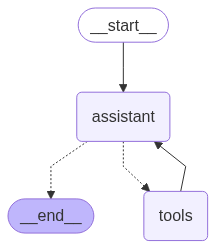

In [68]:
# make the graph responsible for cancel the appointment
graph_builder_cancel = StateGraph(State)

graph_builder_cancel.add_node("tools", ToolNode(cancel_appointment_tools))
graph_builder_cancel.add_node("assistant", Assistant(cancel_appointment_runnable))
graph_builder_cancel.add_edge("tools", "assistant")
graph_builder_cancel.add_conditional_edges("assistant", tools_condition)
graph_builder_cancel.set_entry_point("assistant")

memory_cancel = MemorySaver()
graph_cancel = graph_builder_cancel.compile(checkpointer=memory_cancel)

from IPython.display import Image, display

try:
    display(Image(graph_cancel.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [69]:
thread = {"configurable": {"thread_id": "2"}}
inputs = {"messages": [{"role": "user", "content": "I want to cancel my appoinment with Dr.Smith"}]}
for chunk in graph_cancel.stream(inputs, thread, stream_mode="updates"):
    print(chunk)

Key 'example' is not supported in schema, ignoring


{'assistant': {'messages': AIMessage(content='Ok, I can help with that. First, can you please provide the appointment ID you wish to cancel?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--c9cb01e5-0632-436e-814a-9c8a1640dec6-0', usage_metadata={'input_tokens': 379, 'output_tokens': 23, 'total_tokens': 402, 'input_token_details': {'cache_read': 0}})}}


In [70]:
inputs = {"messages": [{"role": "user", "content": "My id is 2"}]}
for chunk in graph_cancel.stream(inputs, thread, stream_mode="updates"):
    print(chunk)

Key 'example' is not supported in schema, ignoring


{'assistant': {'messages': AIMessage(content='Okay, just to confirm, you wish to cancel the appointment with ID 2?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--89b68149-07f3-46db-90bd-d2a43a3546df-0', usage_metadata={'input_tokens': 406, 'output_tokens': 18, 'total_tokens': 424, 'input_token_details': {'cache_read': 0}})}}


In [71]:
inputs = {"messages": [{"role": "user", "content": "yes"}]}
for chunk in graph_cancel.stream(inputs, thread, stream_mode="updates"):
    print(chunk)

Key 'example' is not supported in schema, ignoring
Key 'example' is not supported in schema, ignoring


{'assistant': {'messages': AIMessage(content='', additional_kwargs={'function_call': {'name': 'cancel_appointment', 'arguments': '{"appointment_id": 2.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--bdff7600-eee4-4c30-ab47-6ee7aef8c12e-0', tool_calls=[{'name': 'cancel_appointment', 'args': {'appointment_id': 2.0}, 'id': 'f323b8cb-0d99-47f5-bfce-e230bed35f97', 'type': 'tool_call'}], usage_metadata={'input_tokens': 424, 'output_tokens': 7, 'total_tokens': 431, 'input_token_details': {'cache_read': 0}})}}
{'tools': {'messages': [ToolMessage(content='{"success": true, "message": "Appointment cancelled successfully."}', name='cancel_appointment', id='c61ebb36-0402-4aba-9bf7-e1f12de4fa85', tool_call_id='f323b8cb-0d99-47f5-bfce-e230bed35f97')]}}
{'assistant': {'messages': AIMessage(content='OK. I have cancelled appointment ID 2.', additional_kwargs={}, respons

In [72]:
# check whether the database is updated

conn = sqlite3.connect(DB_PATH) 
cursor = conn.cursor()

for row in cursor.execute("SELECT * FROM Appointment"):
    print(row)

(1, '10:00', '2025-06-06', 1, 1)
(3, '14:00', '2025-06-07', 3, 3)
(4, '11:00', '2025-06-06', 1, 1)
